<div style="text-align: center;">
    <span style="color: red; font-size: 70px;"> Path Integral Monte-Carlo </span>
</div>

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable

from scipy.stats import norm

Il sistema preso in considerazione è quello di una singola particella posta in un potenziale esterno che presenta due minimi locali in posizioni simmetriche rispetto all'asse delle ordinate. Tale problema può essere studiato con metodi variazionali che consentono di fornire una stima del ground state come stato che minimizza il funzionale energia, oppure con metodi Quantum Monte-Carlo passando per la rappresentazione dei cammini di Feynman. Il potenziale preso in considerazione è pari a:
$$
V\left(x\right)\,=\,x^4\,-\frac{5}{2}x^2
$$

<center>

![Alt text](Immagini/Potenziale.png)

</center>

<center>

## Soluzione esatta

</center>

Per descrivere una funzione d'onda in termini vettoriali possiamo lavorare con un reticolo di punti discreti, equispaziati di una certa quantità costante $dx$ e memorizzare i valori della funzione d'onda in ogni punto. In questo modo $\Psi(x)$ diventa un vettore:

$$
\Psi(x) \to \left[ \Psi(x_1), \Psi(x_2), ..., \Psi(x_N) \right] = 
\left[ \Psi_1, \Psi_2, ..., \Psi_N \right]
$$

Il problema agli autovalori dell'hamiltoniana 

$$
{\hat H} \Psi(x) = \left( -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + V(x) \right) \Psi(x) = E \Psi(x)
$$

può essere riformulato con il formalismo matriciale. Per discretizzare le derivate procediamo come segue, ossia per la derivata prima abbiamo che:
$$
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) \simeq \frac{\Psi_{i+1}-\Psi_{i}}{dx}\\
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right) \simeq \frac{\Psi_{i}-\Psi_{i-1}}{dx}
$$

La derivata seconda può essere invece scritta come

$$
\frac{\partial^2}{\partial x^2} \Psi(x=x_i) =
\frac{\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) - \frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right)}{dx} =
\frac{\Psi_{i+1}-2\Psi_{i}+\Psi_{i-1}}{dx^2}
$$

Il problema così riformulato è il seguente:

$$
\begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
= E
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
$$

Per risolvere il problema agli autovalori dell'Hamiltoniana dobbiamo ora trovare gli autostati e gli autovalori della matrice che abbiamo appena trovato.

In [3]:
def pot(x):
    return x**4-5./2.*x**2

hbar = 1
m = 1     
a = 6.    #grid length
N = 1000  #iterations

x = np.linspace(-a/2.,a/2.,N)
dx = x[1]-x[0]
V = pot(x)

#build the matrix representing Schrodinger's eq
CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

#now psi[0] is the ground state (approximate) wavefunction and E[0] it's energy
print('Energia ground state:',E[0])

Energia ground state: -0.46045845080084263


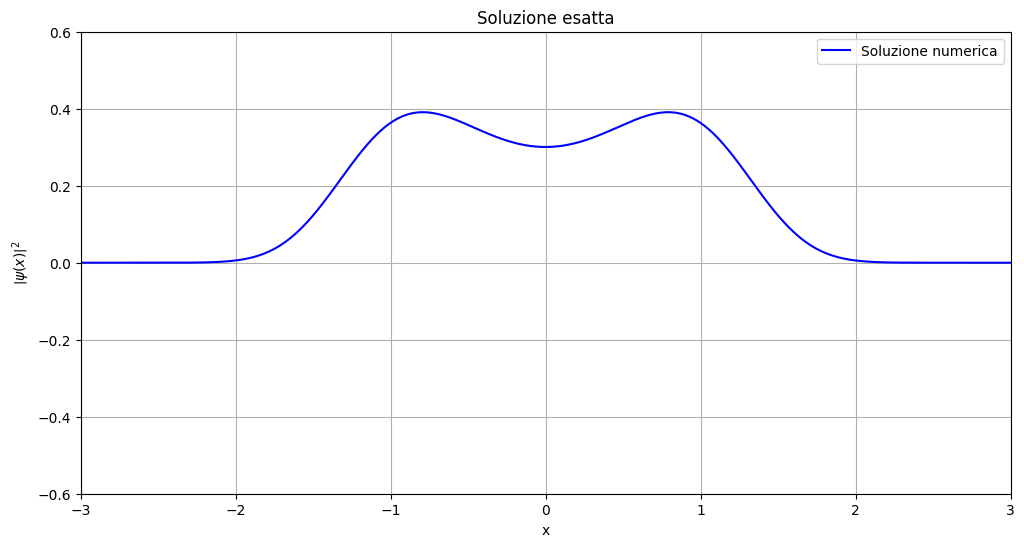

In [4]:
plt.figure(figsize=(12,6))

def PdF(x,sigma,mu):
    N = np.sqrt(2*sigma*np.sqrt(math.pi)*(1+np.exp(-(mu/sigma)**2)))
    return (np.exp(-(((x-mu)/sigma)**2)/2) + np.exp(-(((x+mu)/sigma)**2)/2))/N

x = np.linspace(-a/2, a/2, N)

plt.plot(x,(psi[0])**2, color = 'blue', label = 'Soluzione numerica')

plt.xlabel("x")
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
plt.ylabel(r"$\left|\psi\left(x\right)\right|^2$")
plt.title("Soluzione esatta")

plt.grid(True)
plt.legend()
plt.show()

<center>

## Funzione trial costante

</center>

Iniziamo la nostra analisi lavorando con una funzione trial costante, posta pari ad uno in tutta la regione simulata. Mediante il metodo PIGS, possiamo ottenere la seguente stima della funzione d'onda di ground state dopo un evoluzione immaginaria pari ad $N\,=\,8$.

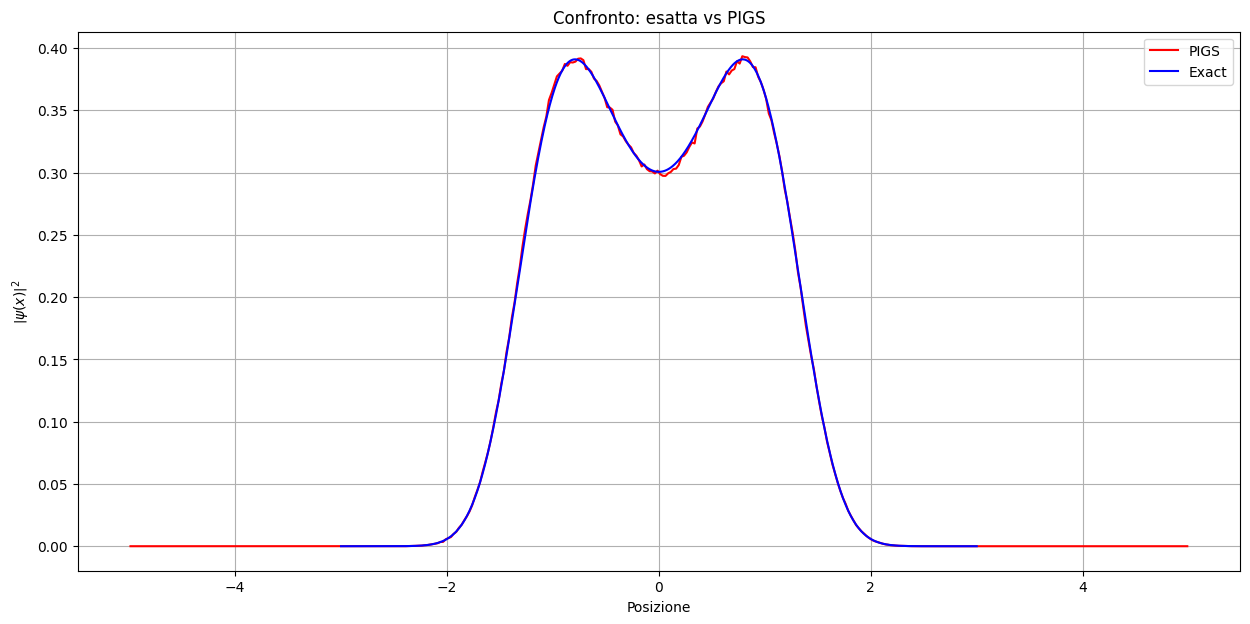

In [5]:
energia = np.loadtxt("Dati/constFuncPIGS.dat", unpack = True)


fig = plt.figure(figsize=(15, 7))

plt.plot(energia[0, :], energia[1, :], 'r', label = 'PIGS')
plt.plot(x, psi[0]**2, 'b', label = 'Exact')
plt.title('Confronto: esatta vs PIGS')
plt.xlabel('Posizione')
plt.ylabel(r'$\left|\psi\left(x\right)\right|^2$')
plt.grid(True)
plt.legend(loc='best')

# Mostra i plot
plt.show()

<center>

## Funzione trial ottimizzata

</center>

Una stima del ground state del sistema quantistico in analisi può essere ottenuta utilizzando il principio variazionale di Ritz, il quale afferma che il valore di aspettazione dell'Hamiltoniana su uno stato prova ha come limite inferiore l'energia del ground state $E_0$:

$$
E_T\,= 
\frac{\langle \Psi_T| {\hat H} | \Psi_T \rangle}
{\langle \Psi_T | \Psi_T \rangle} \ge E_0\,=
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

Per valutare $E_T$ è necessario calcolare un integrale (generalmente multi-dimensionale):
$$
E_T\,= 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$
Nel secondo integrale possiamo interpretare:
$$
p\left(x\right)\,=\,\frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2}
$$
come una distribuzione di probabilità da campionare per poter calcolare con metodi Monte-Carlo l'integrale stesso. Proponendo una funzione d'onda di prova che dipende da una serie di parametri (nel caso studiato saranno due), si può calcolare $E_T$ al variare dei parametri e identificare quali sono quelli che minimizzano il valor medio dell'operatore Hamiltoniana.  Per il principio variazionale di Ritz possiamo aspettarci che i parametri che minimizzano $E_T$ garantiscono una buona approssimazione del ground state. Utilizziamo come modellizzazione della funzione d'onda di ground state la sovrapposizione di due gaussiane disposte simmetricamente rispetto all'asse delle ordinate e con stessa deviazione standard. I parametri sui quali sarà necessario lavorare per ottenere la soluzione ottimizzata sono due: $\mu$ e $\sigma$. La funzione d'onda trial è la seguente:

$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

La normalizzazione di tale funzione d'onda è facilmente ottenibile valutandone l'integrale del modulo quadro. Si ha allora che:

$$
    N^2\,=\,\int_{-\infty}^{+\infty} \left(e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}\right)^2 dx
$$

Svolgendo il quadrato si ottiene che:

$$
    N\,=\,\sqrt{2\sigma\sqrt{\pi}\left(1\,+\,\exp{\left(-\left(\frac{\mu}{\sigma}\right)^2\right)}\right)}
$$
Effettuando un simulated annealing, si ottengono le seguenti stime per sigma e mu.

In [6]:
para = np.loadtxt("Dati/Parametri.dat", unpack = True)

# Definisci la funzione gaussiana
def gaussiana(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

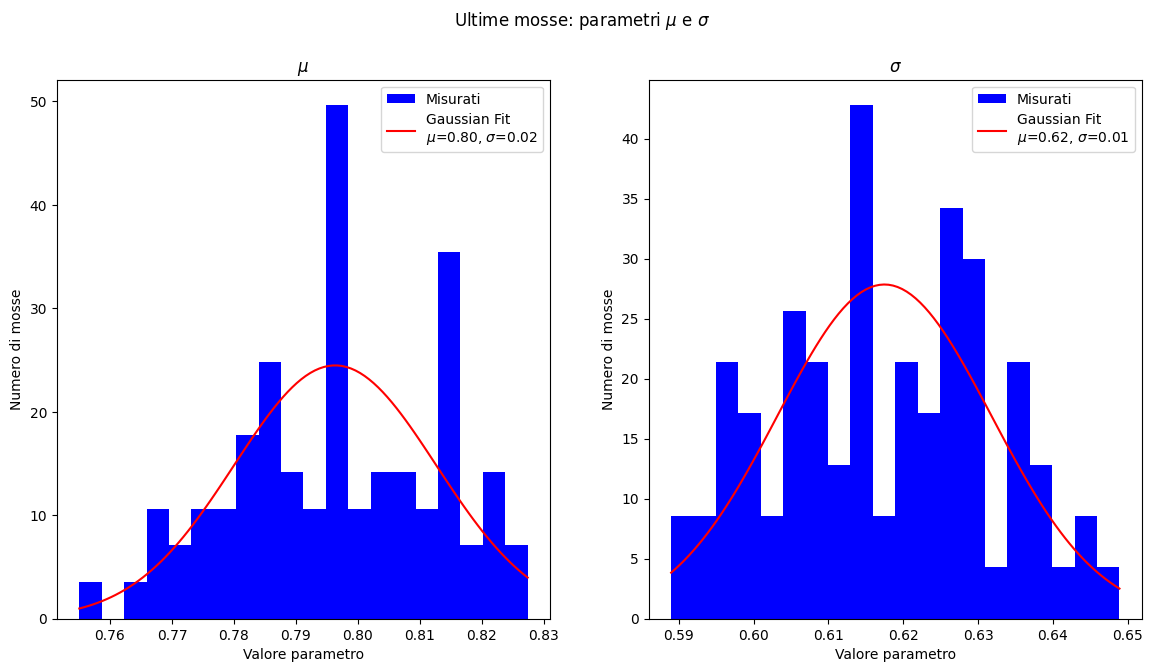

In [7]:
x = para[0, 450:528]
y = para[1, 450:528]

fig, ax = plt.subplots(1, 2, figsize = (14, 7))

for i in range(0, 2):
    if i==0:
        ax[i].hist(x, bins=20, facecolor='blue', density = True, label = 'Misurati')
        ax[i].set_title(r'$\mu$')

        mu1, std1 = norm.fit(x) 
        x1 = np.linspace(x.min(), x.max(), 100)
        y1 = norm.pdf(x1, mu1, std1)
        ax[i].plot(x1, y1, 'r-', label='Gaussian Fit\n$\mu$={:.2f}, $\sigma$={:.2f}'.format(mu1, std1))

        

    else:
        ax[i].hist(y, bins=20, facecolor='blue', density = True, label = 'Misurati')
        ax[i].set_title(r'$\sigma$')

        mu1, std1 = norm.fit(y) 
        x1 = np.linspace(y.min(), y.max(), 100)
        y1 = norm.pdf(x1, mu1, std1)
        ax[i].plot(x1, y1, 'r-', label='Gaussian Fit\n$\mu$={:.2f}, $\sigma$={:.2f}'.format(mu1, std1))
    
    ax[i].set_ylabel('Numero di mosse')
    ax[i].set_xlabel('Valore parametro')
    ax[i].legend()

fig.suptitle(r'Ultime mosse: parametri $\mu$ e $\sigma$')
plt.show()

Procediamo ora alla stima della funzione d'onda di ground state con metodo PIGS, fornendo come funzione d'onda trial quella ricavata con il metodo variazionale presentato in precedenza. Si può osservare che si ottengono dei risultati di un certo rilievo anche nel momento in cui il tempo immaginario d'evoluzione è dimezzato rispetto alla casistca precedente. Stiamo infatti utilizzando in questo caso $N\,=\,4$.

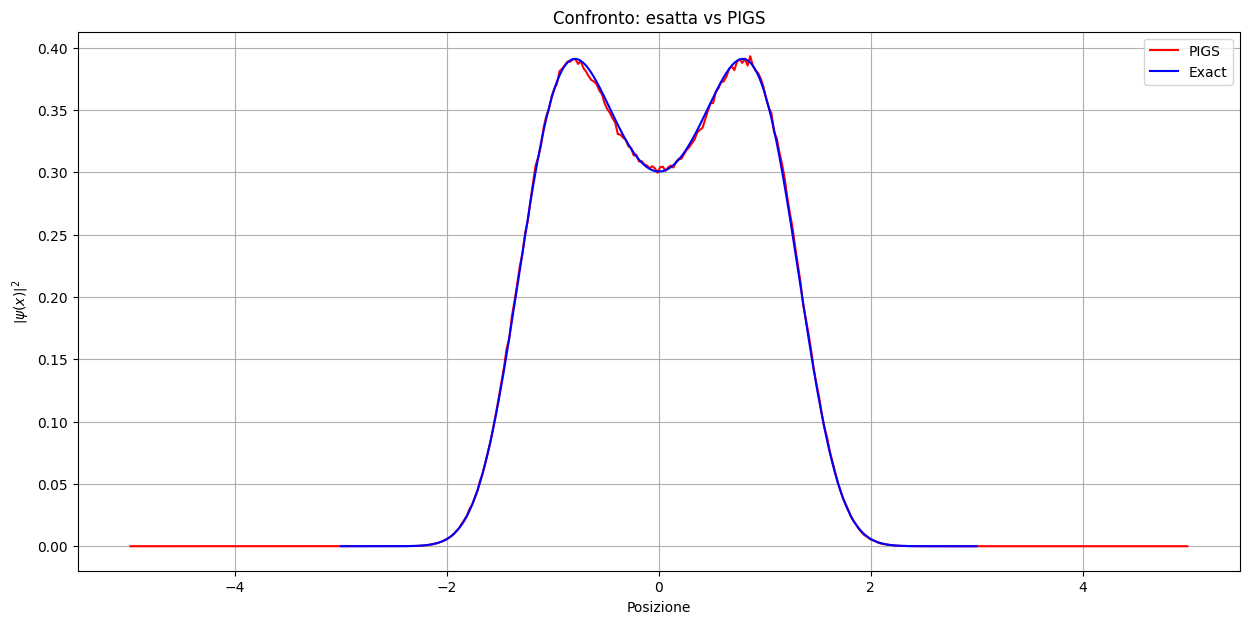

In [8]:
energia = np.loadtxt("Dati/variationalFuncPIGS.dat", unpack = True)


fig = plt.figure(figsize=(15, 7))
x = np.linspace(-a/2.,a/2.,N)

plt.plot(energia[0, :], energia[1, :], 'r', label = 'PIGS')
plt.plot(x, psi[0]**2, 'b', label = 'Exact')
plt.title('Confronto: esatta vs PIGS')
plt.xlabel('Posizione')
plt.ylabel(r'$\left|\psi\left(x\right)\right|^2$')
plt.grid(True)
plt.legend(loc='best')

# Mostra i plot
plt.show()

<center>

## PIMC: aumento temperatura

</center>

Consideriamo ora cosa accade a temperatura finita studiando il problema con metodi PIMC. Nel seguente plot è possibile apprezzare come all'aumentare della temperatura la soluzione diventi meno piccata e pi ampia: questo è un segno inequivocabile di come gli stati eccitati abbiano un peso maggiore sulla funzione di partizione a temperature elevate.

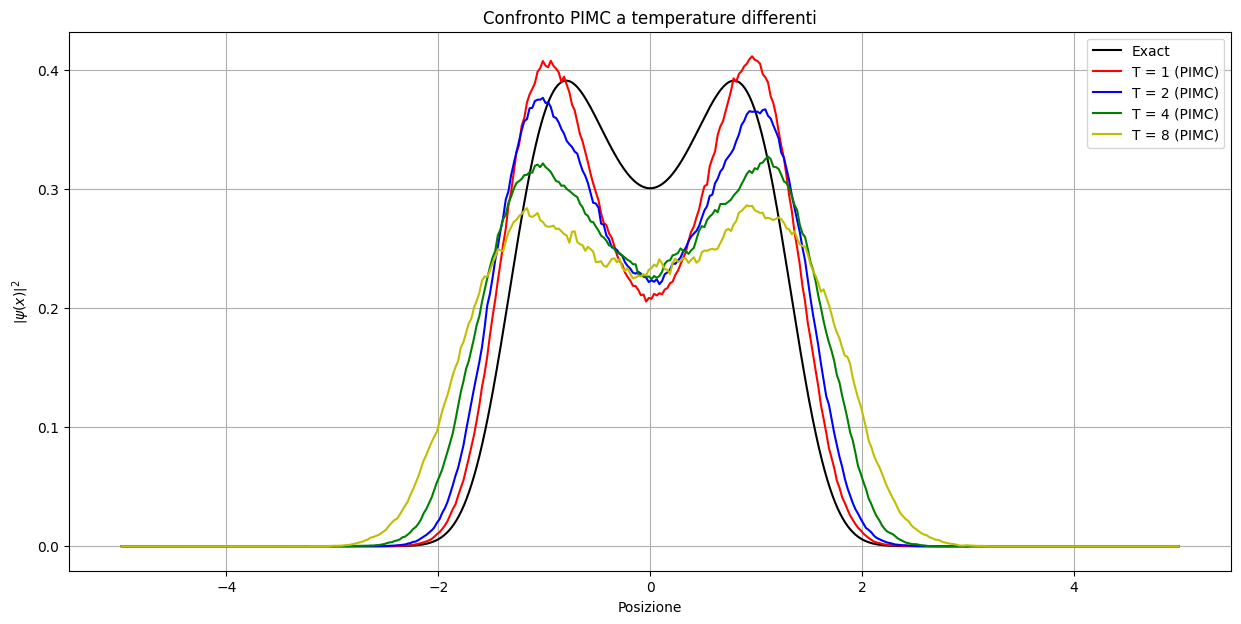

In [10]:
picm1 = np.loadtxt("Dati/picm1.dat", unpack = True)
picm2 = np.loadtxt("Dati/picm2.dat", unpack = True)
picm4 = np.loadtxt("Dati/picm4.dat", unpack = True)
picm8 = np.loadtxt("Dati/picm8.dat", unpack = True)


fig = plt.figure(figsize=(15, 7))
x = np.linspace(-a/2.,a/2.,N)

plt.plot(x, psi[0]**2, 'k', label = 'Exact')
plt.plot(picm1[0, :], picm1[1, :], 'r', label = 'T = 1 (PIMC)')
plt.plot(picm2[0, :], picm2[1, :], 'b', label = 'T = 2 (PIMC)')
plt.plot(picm4[0, :], picm4[1, :], 'g', label = 'T = 4 (PIMC)')
plt.plot(picm8[0, :], picm8[1, :], 'y', label = 'T = 8 (PIMC)')
plt.title('Confronto PIMC a temperature differenti')
plt.xlabel('Posizione')
plt.ylabel(r'$\left|\psi\left(x\right)\right|^2$')
plt.grid(True)
plt.legend(loc='best')

# Mostra i plot
plt.show()